<a href="https://colab.research.google.com/github/FrederickUdis/redNeuronalElectricidad/blob/main/PruebaTecnicaRedNeuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta


In [100]:
#Carga de la data

df = pd.read_csv('/content/consumo_energia_sintetico.csv', parse_dates=['date'])
df['weekday'] = df['weekday'].astype('category')
df = pd.get_dummies(df, columns=['weekday'], drop_first=True)


In [101]:
#Variables temporales

df['dayofyear'] = df['date'].dt.dayofyear
df['sin_dayofyear'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
df['cos_dayofyear'] = np.cos(2 * np.pi * df['dayofyear'] / 365)


In [102]:
#variables tipo lag

for lag in range(1, 8):
    df[f'lag_{lag}'] = df['consumption'].shift(lag)

df['rolling_mean_7'] = df['consumption'].rolling(window=7).mean()
df['temp_lag_1'] = df['temperature'].shift(1)
df['temp_rolling_mean_7'] = df['temperature'].rolling(window=7).mean()


In [103]:
#Limpieza de los datos
df = df.dropna().reset_index(drop=True)


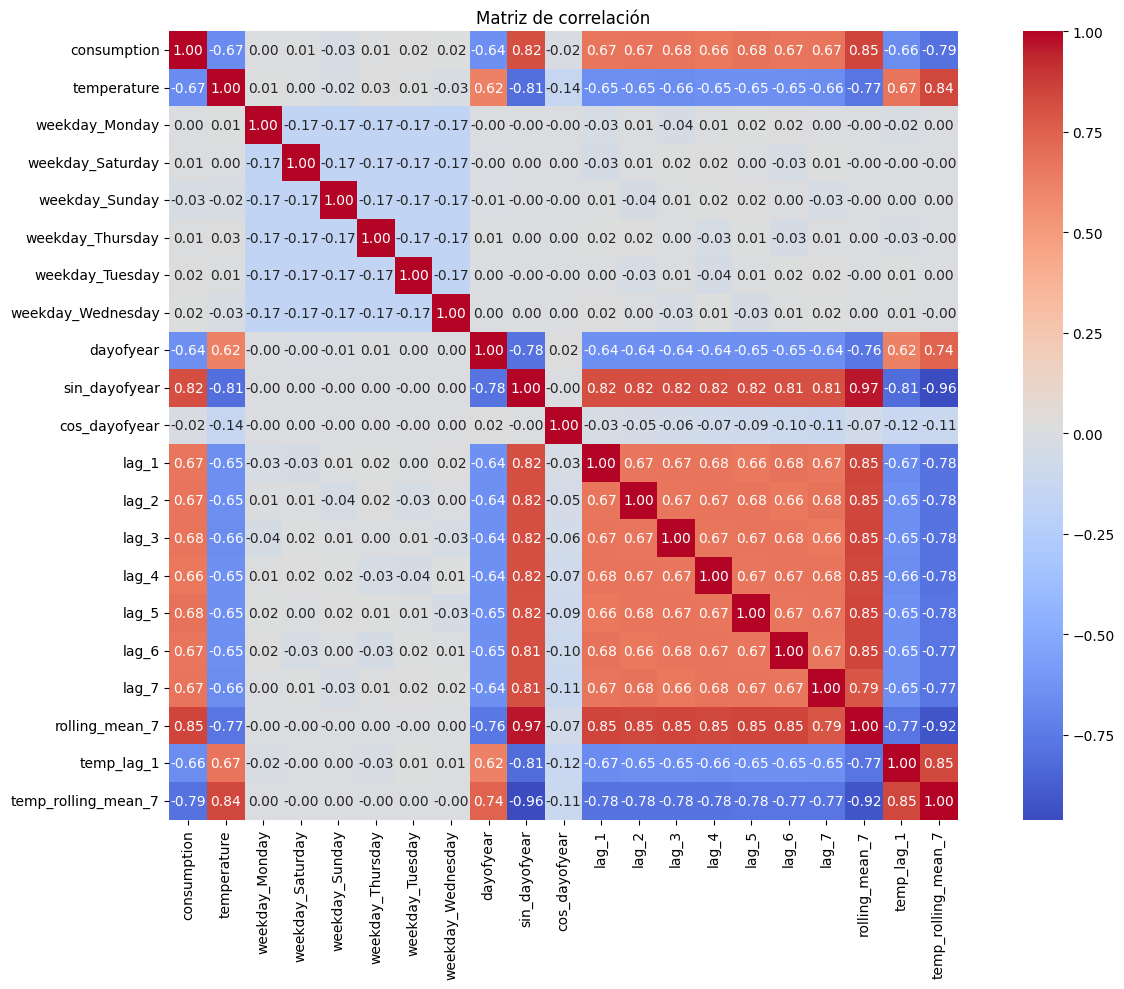

In [104]:
#Matriz de correlacion

correlation_matrix = df.drop(columns=['date']).corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Matriz de correlación')
plt.tight_layout()
plt.show()

In [105]:
#Sleccion de variables predictorias
feature_columns = [
    'temperature', 'temp_lag_1', 'temp_rolling_mean_7',
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
    'rolling_mean_7', 'sin_dayofyear', 'cos_dayofyear'
] + [col for col in df.columns if col.startswith('weekday_')]

In [106]:
#Normalizacion de los datos
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[feature_columns])
y_scaled = scaler_y.fit_transform(df[['consumption']])

In [107]:
#Creacion de series temporales
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i + window_size])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

window_size = 7
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)
X_train, X_val = X_seq[:-30], X_seq[-30:]
y_train, y_val = y_seq[:-30], y_seq[-30:]

In [108]:
#red Neuronal
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

#Entrenamiento
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stop])


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0736 - val_loss: 0.0078
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0114 - val_loss: 0.0059
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0103 - val_loss: 0.0078
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0100 - val_loss: 0.0059
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0106 - val_loss: 0.0063
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0107 - val_loss: 0.0064
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0105 - val_loss: 0.0060


In [109]:
# Prediccion y evaluacion del modelo
y_pred_scaled = model.predict(X_val)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_val_real = scaler_y.inverse_transform(y_val)

mae = mean_absolute_error(y_val_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_val_real, y_pred))
mape = np.mean(np.abs((y_val_real - y_pred) / y_val_real)) * 100
r2 = 1 - (np.sum((y_val_real - y_pred) ** 2) / np.sum((y_val_real - np.mean(y_val_real)) ** 2))
mdae = np.median(np.abs(y_val_real - y_pred))
smape = 100 * np.mean(np.abs(y_val_real - y_pred) / ((np.abs(y_val_real) + np.abs(y_pred)) / 2))

#Metricas adicionales
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'R² Score: {r2:.4f}')
print(f'Mediana del Error Absoluto (MdAE): {mdae:.2f}')
print(f'SMAPE: {smape:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
MAE: 6.22
RMSE: 7.79
MAPE: 4.27%
R² Score: 0.2361
Mediana del Error Absoluto (MdAE): 4.20
SMAPE: 4.27%


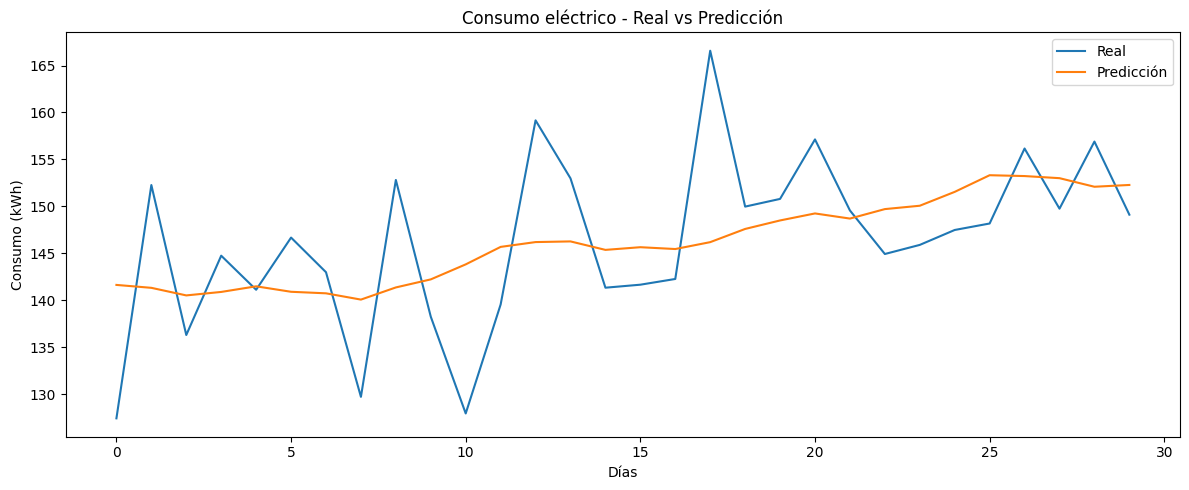

In [110]:
#Visualizacion de resultados
plt.figure(figsize=(12, 5))
plt.plot(y_val_real, label='Real')
plt.plot(y_pred, label='Predicción')
plt.title('Consumo eléctrico - Real vs Predicción')
plt.xlabel('Días')
plt.ylabel('Consumo (kWh)')
plt.legend()
plt.tight_layout()
plt.show()


In [111]:
print(df['consumption'].mean())

150.28838383838382


In [112]:
mape = np.mean(np.abs((y_val_real - y_pred) / y_val_real)) * 100
print(f'MAPE: {mape:.2f}%')


MAPE: 4.27%


In [113]:
#Prediccion 7 dias despues

last_sequence = X_scaled[-window_size:]
predictions_scaled = []
input_seq = last_sequence.copy()

for _ in range(7):
    pred_scaled = model.predict(input_seq.reshape(1, window_size, X_scaled.shape[1]), verbose=0)
    predictions_scaled.append(pred_scaled[0])

    # Reemplaza solo la columna de 'consumption' (que es la target)
    next_step = input_seq[-1].copy()
    next_step[feature_columns.index('lag_1')] = pred_scaled[0]

    # Desplaza la ventana y añade el nuevo paso
    input_seq = np.vstack((input_seq[1:], next_step))

future_predictions = scaler_y.inverse_transform(predictions_scaled)

last_date = df['date'].max()
future_dates = [last_date + timedelta(days=i) for i in range(1, 8)]

pred_df = pd.DataFrame({
    'Fecha': future_dates,
    'Consumo_Pronosticado_kWh': future_predictions.flatten()
})

print(pred_df)


<ipython-input-113-158cdeeb38d3>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_step[feature_columns.index('lag_1')] = pred_scaled[0]


       Fecha  Consumo_Pronosticado_kWh
0 2023-01-01                152.109041
1 2023-01-02                152.477400
2 2023-01-03                155.347433
3 2023-01-04                156.997695
4 2023-01-05                158.287666
5 2023-01-06                158.203398
6 2023-01-07                159.523435


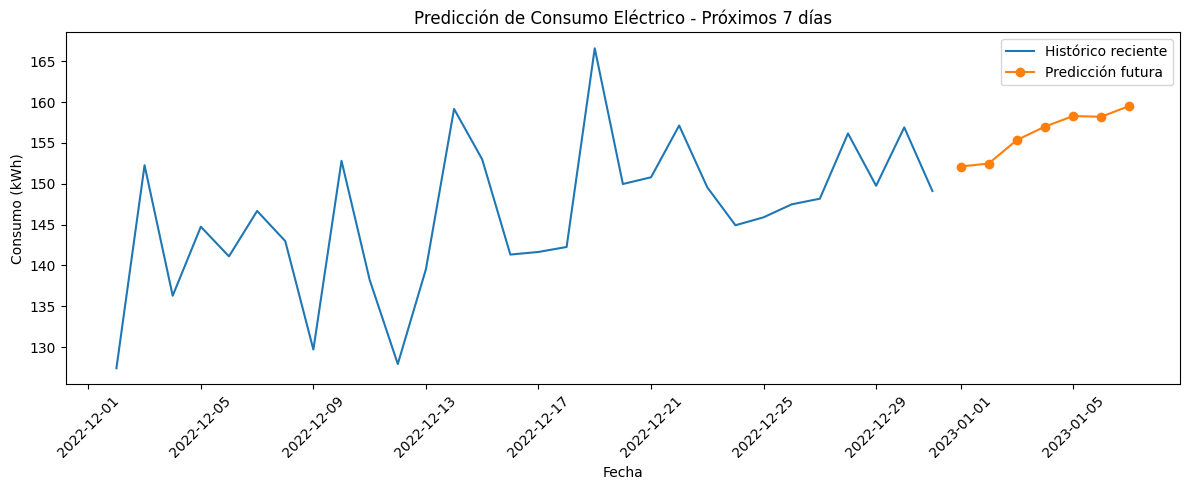

In [114]:
#Grafica de la prediccion
plt.figure(figsize=(12, 5))
plt.plot(df['date'][-30:], df['consumption'][-30:], label='Histórico reciente')
plt.plot(pred_df['Fecha'], pred_df['Consumo_Pronosticado_kWh'], label='Predicción futura', marker='o')
plt.title('Predicción de Consumo Eléctrico - Próximos 7 días')
plt.xlabel('Fecha')
plt.ylabel('Consumo (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Evaluacion de la precision futura


In [115]:
def evaluar_precision_futura(df, X_scaled, y_scaled, feature_columns, window_size, scaler_y, model, dias_a_predecir=7, desde=-60):
    predicciones = []
    reales = []

    for i in range(desde, desde + dias_a_predecir):
        secuencia = X_scaled[i - window_size:i]
        real = y_scaled[i]

        pred_scaled = model.predict(secuencia.reshape(1, window_size, X_scaled.shape[1]), verbose=0)
        predicciones.append(pred_scaled[0])
        reales.append(real)

    pred_invertido = scaler_y.inverse_transform(predicciones)
    real_invertido = scaler_y.inverse_transform(reales)

    mae = mean_absolute_error(real_invertido, pred_invertido)
    mape = np.mean(np.abs((real_invertido - pred_invertido) / real_invertido)) * 100
    precision = 100 - mape

    print(f"MAE simulación: {mae:.2f}")
    print(f"MAPE simulación: {mape:.2f}%")
    print(f"Precisión estimada: {precision:.2f}%")

    return pred_invertido, real_invertido


In [116]:
evaluar_precision_futura(df, X_scaled, y_scaled, feature_columns, window_size, scaler_y, model)


MAE simulación: 10.60
MAPE simulación: 8.05%
Precisión estimada: 91.95%


(array([[136.89548381],
        [136.09803496],
        [134.60656854],
        [134.5903748 ],
        [134.78244681],
        [135.62805957],
        [136.98812231]]),
 array([[120.71],
        [118.5 ],
        [135.58],
        [144.  ],
        [150.57],
        [129.34],
        [144.92]]))

In [117]:
pred_simulado, real_simulado = evaluar_precision_futura(
    df, X_scaled, y_scaled, feature_columns, window_size, scaler_y, model
)

MAE simulación: 10.60
MAPE simulación: 8.05%
Precisión estimada: 91.95%


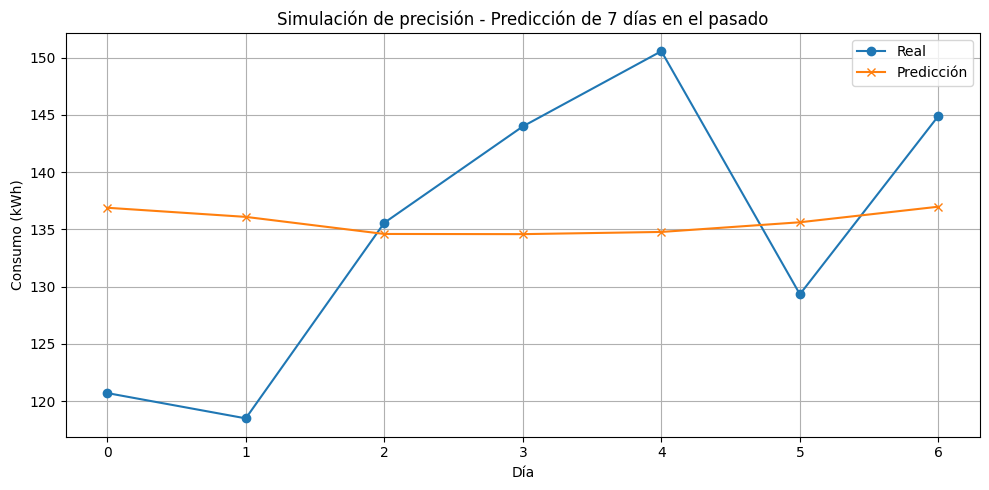

In [118]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(real_simulado, label='Real', marker='o')
plt.plot(pred_simulado, label='Predicción', marker='x')
plt.title('Simulación de precisión - Predicción de 7 días en el pasado')
plt.xlabel('Día')
plt.ylabel('Consumo (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##Entrenamiento de segunda RedNeuronal con mas variables

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0675 - val_loss: 0.0067
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0106 - val_loss: 0.0065
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0107 - val_loss: 0.0066
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0098 - val_loss: 0.0067
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0103 - val_loss: 0.0062
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0097 - val_loss: 0.0066
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0108 - val_loss: 0.0061
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0109 - val_loss: 0.0065
Epoch 9/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0109 - val_loss: 0.0061
Epoch 10/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0105 - val_loss: 0.0081
Epoch 11/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0105 - val_loss: 0.0062
Epoch 12/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - los

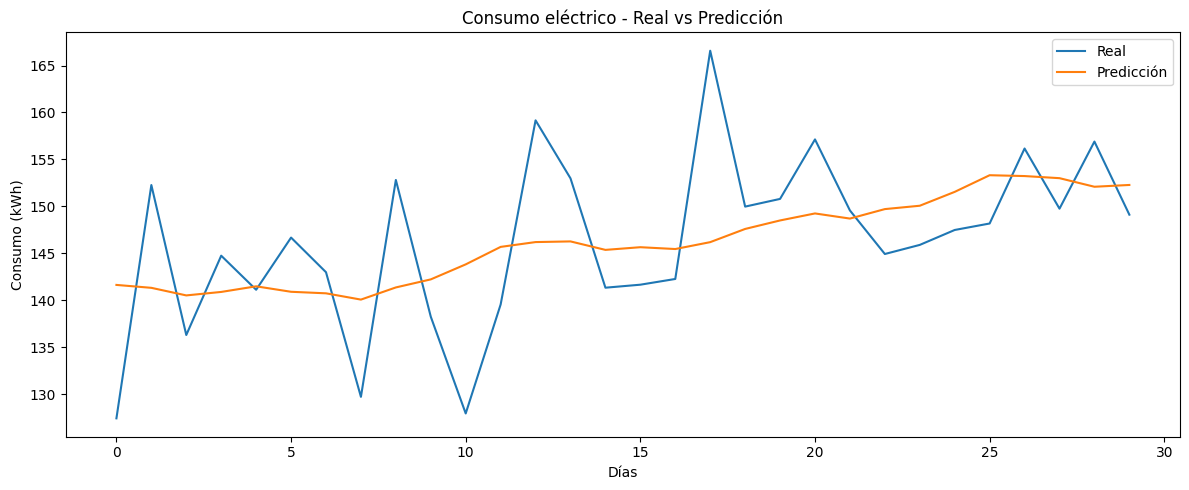

In [119]:
df2 = pd.read_csv('/content/consumo_energia_sintetico.csv', parse_dates=['date'])
df2['weekday'] = df2['weekday'].astype('category')
df2 = pd.get_dummies(df2, columns=['weekday'], drop_first=True)

df2['dayofyear'] = df2['date'].dt.dayofyear
df2['weekday_num'] = df2['date'].dt.weekday
df2['sin_dayofyear'] = np.sin(2 * np.pi * df2['dayofyear'] / 365)
df2['cos_dayofyear'] = np.cos(2 * np.pi * df2['dayofyear'] / 365)
df2['sin_weekday'] = np.sin(2 * np.pi * df2['weekday_num'] / 7)
df2['cos_weekday'] = np.cos(2 * np.pi * df2['weekday_num'] / 7)
df2['is_weekend'] = df2['weekday_num'].isin([5, 6]).astype(int)

for lag in range(1, 8):
    df2[f'lag_{lag}'] = df2['consumption'].shift(lag)

df2['trend_7'] = df2['consumption'] - df2['lag_7']
df2['rolling_mean_7'] = df2['consumption'].rolling(window=7).mean()
df2['rolling_std_7'] = df2['consumption'].rolling(window=7).std()
df2['rolling_min_7'] = df2['consumption'].rolling(window=7).min()
df2['rolling_max_7'] = df2['consumption'].rolling(window=7).max()

df2['temp_lag_1'] = df2['temperature'].shift(1)
df2['temp_rolling_mean_7'] = df2['temperature'].rolling(window=7).mean()

df2 = df2.dropna().reset_index(drop=True)

feature_columns = [
    'temperature', 'temp_lag_1', 'temp_rolling_mean_7',
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
    'rolling_mean_7', 'rolling_std_7', 'rolling_min_7', 'rolling_max_7',
    'trend_7', 'sin_dayofyear', 'cos_dayofyear',
    'sin_weekday', 'cos_weekday', 'is_weekend'
] + [col for col in df2.columns if col.startswith('weekday_')]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df2[feature_columns])
y_scaled = scaler_y.fit_transform(df2[['consumption']])

def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i + window_size])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

window_size = 7
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)
X_train, X_val = X_seq[:-30], X_seq[-30:]
y_train, y_val = y_seq[:-30], y_seq[-30:]

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stop])
#metricas adicionales
mae = mean_absolute_error(y_val_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_val_real, y_pred))
mape = np.mean(np.abs((y_val_real - y_pred) / y_val_real)) * 100
r2 = 1 - (np.sum((y_val_real - y_pred) ** 2) / np.sum((y_val_real - np.mean(y_val_real)) ** 2))
mdae = np.median(np.abs(y_val_real - y_pred))
smape = 100 * np.mean(np.abs(y_val_real - y_pred) / ((np.abs(y_val_real) + np.abs(y_pred)) / 2))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'R² Score: {r2:.4f}')
print(f'Mediana del Error Absoluto (MdAE): {mdae:.2f}')
print(f'SMAPE: {smape:.2f}%')

mae = mean_absolute_error(y_val_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_val_real, y_pred))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

plt.figure(figsize=(12, 5))
plt.plot(y_val_real, label='Real')
plt.plot(y_pred, label='Predicción')
plt.title('Consumo eléctrico - Real vs Predicción')
plt.xlabel('Días')
plt.ylabel('Consumo (kWh)')
plt.legend()
plt.tight_layout()
plt.show()
